In [229]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from copy import deepcopy

from sklearn.utils import shuffle

%matplotlib inline

In [230]:
from importlib import reload

In [231]:
sub = pd.read_csv('McK_SubmissionFormat.csv')

In [232]:
sub.head()

,offer_gk,driver_response
0,152446,NaN
1,281031,NaN
2,779964,NaN
3,16720,NaN
4,492087,NaN


In [233]:
test = pd.read_csv('CAX_TestData_McK.csv')
train = pd.read_csv('CAX_TrainingData_McK.csv')

In [234]:
inter = set(train['order_gk']) & (set(test['order_gk']))

In [235]:
interoffers_train = [x for x in train['order_gk'] if x in inter]
interoffers_test = [x for x in test['order_gk'] if x in inter]

In [236]:
len(interoffers_train), len(interoffers_test), len(inter)

(10, 11, 7)

In [237]:
len(test['order_gk'])

237813

In [238]:
train.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [239]:
len(train[train['distance_km'] == -1])/ train.shape[0]

0.2848624793710654

In [240]:
len(train[train['driver_response'] == 1]) / train.shape[0],  train.shape[0]

(0.7402305959171235, 892557)

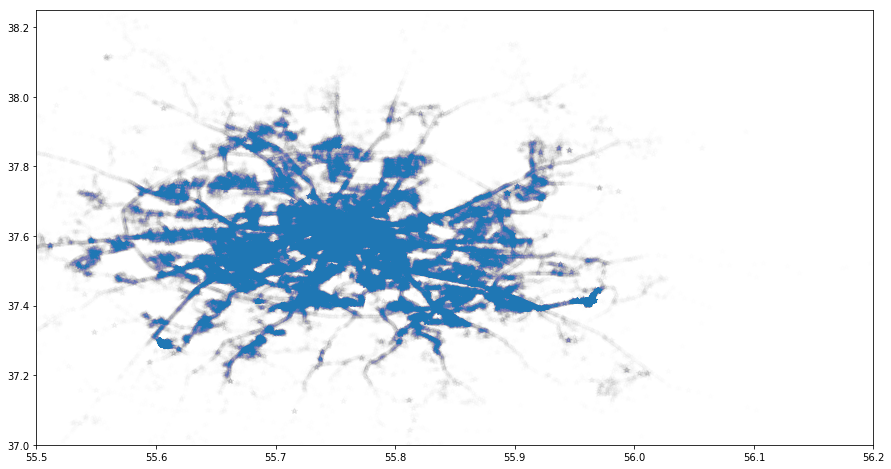

In [241]:
plt.figure(figsize=(15,8))
plt.plot(train['driver_latitude'], train['driver_longitude'], '*',alpha=0.002)
plt.xlim([55.5,56.2])
plt.ylim([37,38.25])
plt.show()

In [242]:
data = pd.concat([train, test], axis=0, ignore_index=True)

In [243]:
np.array(test.index)

array([     0,      1,      2, ..., 237810, 237811, 237812])

In [244]:
data.shape, train.shape, test.shape

((1130370, 14), (892557, 14), (237813, 14))

In [245]:
len(set(data.index)) == data.shape[0]

True

In [246]:
grouped = data.groupby(['weekday_key', 'hour_key']).count()['offer_gk']

In [247]:
pd.DataFrame(grouped).head()

offer_gk
weekday_key hour_key          
0           0             9951
            1             7501
            2             5626
            3             4478
            4             3789

In [248]:
# for i, ind in enumerate(grouped.index):
#     print(i, grouped[ind])

In [249]:
np.min([grouped[ind] for i, ind in enumerate(grouped.index)])

901

In [250]:
grouped_all = data.groupby(['weekday_key', 'hour_key'])

In [251]:
def add_dist_to_centr(df):
    center = [55.75370903771494, 37.61981338262558]
    df['driver_dist_to_centr'] = ((df['driver_latitude'] - center[0]) ** 2 + \
        (df['driver_longitude'] - center[1]) ** 2) ** 0.5
    df['origin_dist_to_centr'] = ((df['origin_order_latitude'] - center[0]) ** 2 + \
        (df['origin_order_longitude'] - center[1]) ** 2) ** 0.5
    return df

In [252]:
train.shape

(892557, 14)

In [253]:
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0.0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1.0
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0.0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1.0
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1.0


In [254]:
import gaussian_mixture_anomaly_detection

In [255]:
reload(gaussian_mixture_anomaly_detection)

<module 'gaussian_mixture_anomaly_detection' from '/Users/sergmiller/Documents/code/python/mckinzie/gaussian_mixture_anomaly_detection.py'>

In [256]:
def cluster_likelihood(df):
    '''
        accept ONLY non-discrete numeric columns without targets,
        df MUST have weekday_key and hour_key columns
    '''
    df = deepcopy(df)
    grouped = df.groupby(['weekday_key', 'hour_key']).count()[df.columns[4]]
    need_size = np.min([grouped[ind] for ind in grouped.index])
    df = df.sample(frac=1)
    ind_perm = df.index
    df = df.reindex(np.arange(df.shape[0]))
    
    days = np.arange(7)
    hours = np.arange(24)
    
    times = df['weekday_key'] * 7 + df['hour_key']
    
    frames = []
    
    print('Gathering time-partitions')
    
    
    for day in tqdm(days, position=0):
        for hour in hours:
            frames.append(np.array(
                df[df['weekday_key'] == day][df['hour_key'] == hour].drop
                (['weekday_key', 'hour_key'],axis=1).iloc[:need_size]
            ))
    frames = np.array(frames)
    
    print(frames.shape)
    frames = frames.reshape((need_size, 24 * 7, -1))
    print(frames.shape)
    detector = gaussian_mixture_anomaly_detection.GaussianMixtureInTimeAnomalyDetector(
        tol=1e-6, n_components=10, max_iter=1000)
    detector.fit(frames)
    print(times.shape)
    print(df.shape)
    print(df.drop(['weekday_key', 'hour_key'],axis=1).shape)
    likelihoods = detector.predict(df.drop(['weekday_key', 'hour_key'],axis=1), times) 
    df['anomaly_ll'] = likelihoods
    df.index = ind_perm
    df = df.sort_index()
    return df['anomaly_ll']

In [257]:
#     weekday_count = pd.DataFrame(df.groupby(['weekday_key']).size())
#     weekday_count.columns = ['weekday_overall_offers']
#     weekday_count['weekday_key'] = weekday_count.index
#     hour_count = pd.DataFrame(df.groupby(['hour_key']).size())
#     hour_count.columns = ['hour_overall_offers']
#     hour_count['hour_key'] = hour_count.index
#     weekday_hour_count = pd.DataFrame(df.groupby(['weekday_key', 'hour_key']).size())
#     weekday_hour_count.columns = ['weekday_hour_overall_offers']

In [258]:
def add_count_per_day_factors(df):
    weekday_count = pd.DataFrame(df.groupby(['weekday_key']).size())
    weekday_count.columns = ['weekday_overall_offers']
    weekday_count['weekday_key'] = weekday_count.index
    hour_count = pd.DataFrame(df.groupby(['hour_key']).size())
    hour_count.columns = ['hour_overall_offers']
    hour_count['hour_key'] = hour_count.index
    weekday_hour_count = pd.DataFrame(df.groupby(['weekday_key', 'hour_key']).size())
    weekday_hour_count.columns = ['weekday_hour_overall_offers']
    
    df = df.join(weekday_count, on='weekday_key', lsuffix='', rsuffix='_2').drop(['weekday_key_2'], axis=1)
    df = df.join(hour_count, on='hour_key', lsuffix='', rsuffix='_2').drop(['hour_key_2'], axis=1)
    df = df.join(weekday_hour_count, on=['weekday_key', 'hour_key'], lsuffix='', rsuffix='_2')
    return df

def add_overall_offers_factors(train, test, subdf):
    weekday_count = pd.DataFrame(train.groupby(['weekday_key']).size())
    weekday_count.columns = ['weekday_overall_offers']
    weekday_count['weekday_key'] = weekday_count.index
    hour_count = pd.DataFrame(train.groupby(['hour_key']).size())
    hour_count.columns = ['hour_overall_offers']
    hour_count['hour_key'] = hour_count.index
    weekday_hour_count = pd.DataFrame(train.groupby(['weekday_key', 'hour_key']).size())
    weekday_hour_count.columns = ['weekday_hour_overall_offers']

    weekday_count = subdf.groupby(['weekday_key'])['weekday_key'].agg({'weekday_key_orders' : 'size'}).reset_index()
    hour_count = subdf.groupby(['hour_key'])['hour_key'].agg({'hour_key_orders' : 'size'}).reset_index()
    weekday_hour_count = subdf.groupby(['weekday_key', 'hour_key'])[['hour_key', 'weekday_key']].agg({'weekday_hour_key_orders' : 'size'}).reset_index()
    train = train.merge(weekday_count, on='weekday_key')
    train = train.merge(hour_count, on='hour_key')
    train = train.merge(weekday_hour_count, on=['weekday_key', 'hour_key'])
    test = test.merge(weekday_count, on='weekday_key')
    test = test.merge(hour_count, on='hour_key')
    test = test.merge(weekday_hour_count, on=['weekday_key', 'hour_key'])
    
def add_mean_std_factors(train, test):
    weekday_count = pd.DataFrame(train.groupby(['weekday_key']).size())
    weekday_count.columns = ['weekday_overall_offers']
    weekday_count['weekday_key'] = weekday_count.index
    hour_count = pd.DataFrame(train.groupby(['hour_key']).size())
    hour_count.columns = ['hour_overall_offers']
    hour_count['hour_key'] = hour_count.index
    weekday_hour_count = pd.DataFrame(train.groupby(['weekday_key', 'hour_key']).size())
    weekday_hour_count.columns = ['weekday_hour_overall_offers']


    
    for sl in [['driver_gk'], ['driver_gk', 'weekday_key'], ['driver_gk', 'hour_key']]:
        for column in ["hour_key", "driver_latitude", "driver_longitude", "origin_order_latitude", "origin_order_longitude", "distance_km"]:
            current_mean = train.groupby(sl)[column].agg({column + "_" + ' '.join(sl) + "_mean": "mean", column + "_" + ' '.join(sl) +"_std": "std"}).reset_index()
            train = train.merge(current_mean, on=sl)
            test = test.merge(current_mean, how="left", on=sl)
            
def full_expander(train, test, df):
    add_overall_offers_factors(train ,test, df)
    add_mean_std_factors(train, test)

In [259]:
y_train = train['driver_response']
X_train = train.drop(['driver_response'],axis=1)
X_test = test.drop(['driver_response'],axis=1)
X_all = data.drop(['driver_response'],axis=1)

In [260]:
X_train = add_dist_to_centr(X_train)
X_test = add_dist_to_centr(X_test)
X_all = add_dist_to_centr(X_all)

In [261]:
X_train.shape, X_test.shape

((892557, 15), (237813, 15))

In [262]:
X_train.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_dist_to_centr,origin_dist_to_centr
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0.292593,0.271707
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,0.116820,0.166860
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0.278720,0.272677
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,0.198218,0.188961
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,0.110147,0.109555


In [89]:
%%time
likelihood = cluster_likelihood(X_train.drop(
    ['offer_gk','offer_class_group','ride_type_desc','driver_gk','order_gk'],axis=1))
likelihood_all = cluster_likelihood(X_all.drop(
    ['offer_gk','offer_class_group','ride_type_desc','driver_gk','order_gk'],axis=1))

  0%|          | 0/7 [00:00<?, ?it/s]

Gathering time-partitions


/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


(168, 760, 11)
(760, 168, 11)
Run fitting


  0%|          | 2/760 [00:00<00:43, 17.33it/s]

Start probabilities memorization


100%|██████████| 760/760 [00:32<00:00, 23.22it/s]


(892557,)
(892557, 13)
(892557, 11)
Normalization


  0%|          | 395/892557 [00:00<03:46, 3946.45it/s]

Start prediction calc


  0%|          | 0/7 [00:00<?, ?it/s]

Gathering time-partitions


100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


(168, 901, 11)
(901, 168, 11)
Run fitting


  0%|          | 3/901 [00:00<00:34, 26.05it/s]

Start probabilities memorization


100%|██████████| 901/901 [00:43<00:00, 20.72it/s]


(1130370,)
(1130370, 13)
(1130370, 11)
Normalization


  0%|          | 278/1130370 [00:00<06:46, 2778.39it/s]

Start prediction calc


100%|██████████| 1130370/1130370 [05:48<00:00, 3246.25it/s]


CPU times: user 10min 57s, sys: 35.5 s, total: 11min 32s
Wall time: 11min 46s


In [263]:
np.save('ll', np.array(likelihood))
np.save('ll_all', np.array(likelihood_all))

In [264]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator

In [265]:
X_train.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_dist_to_centr,origin_dist_to_centr
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0.292593,0.271707
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,0.116820,0.166860
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0.278720,0.272677
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,0.198218,0.188961
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,0.110147,0.109555


In [266]:
from joblib import Parallel, delayed
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

from catboost import Pool

In [271]:
def find_cats(df, cats):
    inds = []
    for i, col in enumerate(df.columns):
        if col in cats:
            inds.append(i)
    return inds
      
def custom_cross_val_score(X, y, groups, estimator, expander, cats, cv=4):
    X = deepcopy(X)
    y = deepcopy(y)
    np.random.seed(42)
    X['target'] = y
    X = X.sample(frac=1)
    X.index = np.arange(X.shape[0])
    y = X['target']
    X = X.drop(['target'],axis=1)
    res = []
    
    for inds_train, inds_test in GroupKFold(n_splits=cv).split(X, y, groups):
        X_train, X_test = X.iloc[inds_train], X.iloc[inds_test]
        y_train, y_test = y[inds_train], y[inds_test]
#         expander(X_train, X_test,  
#                  X_train[['weekday_key', 'hour_key', 'order_gk']].drop_duplicates())
        cats_inds = find_cats(X_train, cats)
        train_pool = Pool(X_train, label=y_train, cat_features=cats_inds)
        test_pool = Pool(X_test, cat_features=cats_inds)
        estimator.fit(train_pool, plot=True, eval_set=test_pool)
        res.append(roc_auc_score(y_true=y_test, y_score=estimator.predict_proba(test_pool)[:, 1]))
        print(res[-1])
        
    return res

In [268]:
X_train.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_dist_to_centr,origin_dist_to_centr
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0.292593,0.271707
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,0.116820,0.166860
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0.278720,0.272677
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,0.198218,0.188961
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,0.110147,0.109555


In [269]:
cats = ['weekday_key', 'hour_key', 
                              'driver_gk', 
                              'offer_class_group',
        'ride_type_desc', 'order_gk', 'offer_gk',
       ]

In [ ]:
%%time
res = custom_cross_val_score(X_train, y_train, 
                        expander=full_expander, 
                        groups=X_train['order_gk'],
                        estimator=CatBoostClassifier(
                                random_seed=1, 
                                iterations=50,
                                rsm=0.1,
                                depth=7,
                                learning_rate=0.005,
                                thread_count=4,
                                eval_metric='AUC',
                                loss_function='Logloss',
                                ),
                        cats=cats,    
                        cv=4,
                )

print(np.mean(res), np.std(res), res)

A Jupyter Widget

Test target is constant or not set.
0.926157968557


A Jupyter Widget

Test target is constant or not set.

Iteration with suspicious time 138 sec ignored in overall statistics.

Iteration with suspicious time 216 sec ignored in overall statistics.
0.924847635071


A Jupyter Widget

Test target is constant or not set.


In [175]:
 print(list(GroupKFold(n_splits=3).split(X=[[0],[1],[2],[3],[4],[5]],y=[0,1,0,1,1,0],groups=[0,2,10,10,0,2])))

[(array([0, 1, 4, 5]), array([2, 3])), (array([0, 2, 3, 4]), array([1, 5])), (array([1, 2, 3, 5]), array([0, 4]))]


In [106]:
Train_exp = pd.concat((X_train, likelihood), axis=1)

In [103]:
likelihood_all = np.clip(likelihood_all,a_max=20, a_min=-20)

(array([   634.,     68.,     63.,     87.,    127.,    118.,    148.,
           167.,    196.,    250.,    307.,    376.,    431.,    576.,
           632.,    860.,   1011.,   1162.,   1320.,   1554.,   2005.,
          2274.,   2557.,   3103.,   3538.,   4375.,   5676.,   7798.,
         10335.,  14398.,  19298.,  23093.,  26258.,  27924.,  25046.,
         20259.,  12565.,   7198.,   2984.,   1088.]),
 array([-20.        , -19.44501426, -18.89002853, -18.33504279,
        -17.78005705, -17.22507132, -16.67008558, -16.11509984,
        -15.56011411, -15.00512837, -14.45014264, -13.8951569 ,
        -13.34017116, -12.78518543, -12.23019969, -11.67521395,
        -11.12022822, -10.56524248, -10.01025674,  -9.45527101,
         -8.90028527,  -8.34529953,  -7.7903138 ,  -7.23532806,
         -6.68034232,  -6.12535659,  -5.57037085,  -5.01538512,
         -4.46039938,  -3.90541364,  -3.35042791,  -2.79544217,
         -2.24045643,  -1.6854707 ,  -1.13048496,  -0.57549922,
         -0.02

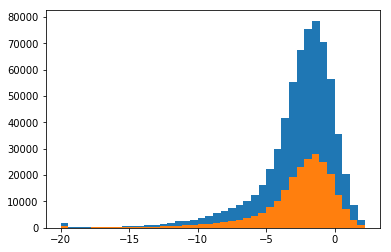

In [94]:
plt.hist([l for i,l in enumerate(likelihood) if y_train[i] == 1],bins=40)
plt.hist([l for i,l in enumerate(likelihood) if y_train[i] == 0],bins=40)

In [ ]:
plt.hist([l for i,l in enumerate(likelihood) if y_train[i] == 0],bins=40)

In [215]:
def fix_nans(X):
    mode = X.mode(axis=0).iloc[:1]
    for col in mode:
        try:
            mode[col] = np.array(mode[col], dtype=int)
        except:
            pass
    return X.fillna(mode)

def run_model(X_train, X_test, y_train, expander, model, cats):
        X_train = deepcopy(X_train)
        X_test = deepcopy(X_test)
        X_test = fix_nans(X_test)
        print(np.sum(X_test.isnull()))
        print(X_test.head())
        expander(X_train, X_test,  
                 X_train[['weekday_key', 'hour_key', 'order_gk']].drop_duplicates())
        X_train.to_csv('train_expended')
        X_test.to_csv('test_expended')
        cats_inds = find_cats(X_train, cats)
        train_pool = Pool(X_train, label=y_train, cat_features=cats_inds)
        model.fit(train_pool, plot=True)
        test_pool = Pool(X_test, cat_features=cats_inds)
        return model.predict_proba(test_pool)[:, 1]

In [115]:
sum(np.isnan(likelihood_all))

0

In [155]:
X_test.median(axis=0)

offer_gk                       563754.000000
weekday_key                         3.000000
hour_key                           15.000000
driver_gk                        3401.000000
order_gk                       458295.000000
driver_latitude                    55.756797
driver_longitude                   37.581937
origin_order_latitude              55.757251
origin_order_longitude             37.581918
distance_km                         3.874000
duration_min                       10.350000
driver_dist_to_centr                0.103630
origin_dist_to_centr                0.103830
weekday_overall_offers         123701.000000
hour_overall_offers             44148.000000
weekday_hour_overall_offers      6542.000000
dtype: float64

In [148]:
for col in mode:
    try:
        mode[col] = np.array(mode[col], dtype=int)
    except:
        pass

In [149]:
mode

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_dist_to_centr,origin_dist_to_centr,weekday_overall_offers,hour_overall_offers,weekday_hour_overall_offers
0,3,5,21,1126,416701,-1,-1,55,37,-1,-1,Standard,private,68,0,155912,60490,10594


In [136]:
len(X_test.columns)

18

In [170]:
np.sum(X_test.isnull())

offer_gk                       0
weekday_key                    0
hour_key                       0
driver_gk                      0
order_gk                       0
driver_latitude                0
driver_longitude               0
origin_order_latitude          0
origin_order_longitude         0
distance_km                    0
duration_min                   0
offer_class_group              0
ride_type_desc                 0
driver_dist_to_centr           0
origin_dist_to_centr           0
weekday_overall_offers         0
hour_overall_offers            0
weekday_hour_overall_offers    0
dtype: int64

In [150]:
X_test_ = X_test.fillna(mode)

In [163]:
np.sum(X_test.isnull())

offer_gk                       0
weekday_key                    0
hour_key                       0
driver_gk                      0
order_gk                       0
driver_latitude                0
driver_longitude               0
origin_order_latitude          0
origin_order_longitude         0
distance_km                    0
duration_min                   0
offer_class_group              0
ride_type_desc                 0
driver_dist_to_centr           0
origin_dist_to_centr           0
weekday_overall_offers         0
hour_overall_offers            0
weekday_hour_overall_offers    0
dtype: int64

In [175]:
X_train.shape, X_test.shape

((892557, 18), (237813, 18))

In [198]:
X_test.index = X_test.index + X_train.shape[0]

In [217]:
 pd.concat((X_test, pd.DataFrame(likelihood_all.iloc[X_train.shape[0]:])),axis=1).head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_dist_to_centr,origin_dist_to_centr,weekday_overall_offers,hour_overall_offers,weekday_hour_overall_offers,anomaly_ll
892557,152446,5,0,5021,648419,55.763302,37.593368,55.758230,37.613689,17.445,24.367,Premium,private,0.028132,0.007612,155912,40309,5545,-1.272381
892558,281031,5,7,5817,405907,55.755470,37.648689,55.741544,37.622868,-1.000,-1.000,Economy,private,0.028929,0.012543,155912,23721,4338,-2.838028
892559,779964,5,1,3870,894998,55.619002,37.596140,55.615923,37.607872,-1.000,-1.000,Standard,business,0.136771,0.138303,155912,25295,2979,-0.700156
892560,16720,5,13,5607,505054,55.620905,37.606550,55.614517,37.591161,-1.000,-1.000,Standard,private,0.133465,0.142110,155912,38481,6413,-4.555598
892561,492087,5,13,3786,459994,55.893228,37.673552,55.888084,37.662087,-1.000,-1.000,Standard,private,0.149510,0.140868,155912,38481,6413,-0.272425


In [216]:
%%time
pred = run_model(pd.concat((X_train, likelihood_all.iloc[:X_train.shape[0]]),axis=1), 
                 pd.concat((X_test, likelihood_all.iloc[X_train.shape[0]:]),axis=1), y_train, 
                        expander=full_expander, 
                        model=CatBoostClassifier(
                                random_seed=1, 
                                iterations=50,
                                rsm=0.1,
                                depth=7,
                                learning_rate=0.005,
                                thread_count=4,
                                eval_metric='AUC',
                                loss_function='Logloss',
                                ),
                        cats=cats)

offer_gk                       0
weekday_key                    0
hour_key                       0
driver_gk                      0
order_gk                       0
driver_latitude                0
driver_longitude               0
origin_order_latitude          0
origin_order_longitude         0
distance_km                    0
duration_min                   0
offer_class_group              0
ride_type_desc                 0
driver_dist_to_centr           0
origin_dist_to_centr           0
weekday_overall_offers         0
hour_overall_offers            0
weekday_hour_overall_offers    0
anomaly_ll                     0
dtype: int64
        offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
892557    152446            5         0       5021    648419        55.763302   
892558    281031            5         7       5817    405907        55.755470   
892559    779964            5         1       3870    894998        55.619002   
892560     16720            5       

/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


A Jupyter Widget

CPU times: user 4min 57s, sys: 40.3 s, total: 5min 38s
Wall time: 4min 10s


In [211]:
sub['driver_response'] = pred
sub.to_csv('submission_miller_cat_50_iter.csv', index=False)

In [207]:
sub = sub.drop(['driver_responce'],axis=1)

In [212]:
sub

,offer_gk,driver_response
0,152446,0.581160
1,281031,0.618801
2,779964,0.630936
3,16720,0.628830
4,492087,0.625312
5,856083,0.626981
6,646503,0.629427
7,188363,0.626421
8,208361,0.630039
9,950917,0.630023


In [214]:
sub['driver_response'].shape

(237813,)